> Bring in the covariates and all kinds of cool stuff for the counting process

In [60]:
#!pip install numdifftools

In [546]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.special as sc
import os
from IPython.display import display, Image
import plotly.graph_objs as go
import pprint
import math
import statsmodels.discrete.count_model as reg_models

from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Functions

In [625]:
def compute_probabilities(a, r, t, values, pi = 0):
    '''Compute the probability of a person landing in their bucket'''
    if pi == 0:
        return math.log(math.gamma(r+ values)/(math.gamma(r) *math.factorial(values)) * (a/(a+t))**(r)*(t/(a+t))**(values))
    else:
        if values == 0:
            prob1 = pi
            prob2 = (math.gamma(r+ values)/(math.gamma(r) *math.factorial(values)) * (a/(a+t))**(r)*(t/(a+t))**(values)) * (1-pi)
            return math.log(prob1 + prob2)
        else:
            prob2 = (math.gamma(r+ values)/(math.gamma(r) *math.factorial(values)) * (a/(a+t))**(r)*(t/(a+t))**(values)) * (1-pi)
            return math.log(prob2)

def compute_all_probabilities(param,values,t):
    '''compute the probabilities of each person conditioned on how long we have observed them'''
    a,r = param
    x = values
    probs = []
    for i in range(len(values)):
        probs.append(compute_probabilities(a,r,t[i],x[i]))
    return np.sum(probs) * -1

def maximize(values, t):
    func = lambda x: compute_all_probabilities(x, values, t)
    bnds = ((0.00001, None), (0.00001, None))
    x0 = [1., 1.]
    res = minimize(func, x0, bounds=bnds)

    return res.x, res.fun

In [626]:
def log_likelihood_extraction(alpha, expr, data):
    Y,X = dmatrices(expr, data, return_type='dataframe')
    model = sm.GLM(Y, X, family=sm.families.NegativeBinomial(alpha = alpha)).fit()
    return(-1*model.llf)

def reg_maximize(expr, data):
    func = lambda x: log_likelihood_extraction(x, expr, data)
    Y,X = dmatrices(expr, data, return_type='dataframe')
    bnds = ((0, None),)  
    x0 = [0.1]
    res = minimize(func, x0, bounds=bnds)
    model = sm.GLM(Y, X, family=sm.families.NegativeBinomial(alpha = res.x)).fit()
    r = 1/res.x
    a = r/math.exp(model.params[0])
    
    return (['a','r'] + list(model.params.index[0:]),
            [a[0],r[0]] + [math.exp(model.params[0])] + list(model.params[1:]),
            res.fun)

In [876]:
def zip_maximize(expr, data):
    Y,X = dmatrices(expr, data, return_type='dataframe')
    out = reg_models.ZeroInflatedNegativeBinomialP(Y,X,inflation='logit')
    out_res = out.fit(maxiter = 1000)
    r = 1/out_res.params[-1]
    pi = math.exp(out_res.params[0])/(1+math.exp(out_res.params[0]))
    a = r/math.exp(out_res.params[1])
    
    return (['a','r','pi'] + list(out_res.params.index[1:-1]),
        [a,r,pi] + [math.exp(out_res.params[1])] + list(out_res.params[2:-1]),
        -1*out_res.llf)

In [877]:
def forecast_histogram(expr, data, right_censor, zip_ = False):
    if zip_ == False:
        Y,X = dmatrices(expr, data, return_type='dataframe')
        maxed = reg_maximize(expr,data)[1]
        alpha = maxed[0]
        r = maxed[1]
        coef = maxed[3:]
        over_all = []
        coef_exp = np.exp(np.sum(X.iloc[:,1:]* np.array(coef).T,axis = 1))
        for i in coef_exp:
            person = []
            if len(coef) == 0: 
                func = lambda x:math.exp(compute_probabilities(alpha,r, 1,x))
            else:
                func = lambda x:math.exp(compute_probabilities(alpha,r, i,x))
            person = list(map(func,range(right_censor)))
            person.append(1-np.sum(person))
            over_all.append(person)
        return(over_all)
    else:
        Y,X = dmatrices(expr, data, return_type='dataframe')
        maxed = zip_maximize(expr,data)[1]
        alpha = maxed[0]
        r = maxed[1]
        pi = maxed[2]
        coef = maxed[4:]
        over_all = []
        coef_exp = np.exp(np.sum(X.iloc[:,1:]* np.array(coef).T,axis = 1))
        for i in coef_exp:
            person = []
            if len(coef) == 0: 
                func = lambda x:math.exp(compute_probabilities(alpha,r, 1,x, pi = pi))
            else:
                func = lambda x:math.exp(compute_probabilities(alpha,r, i,x, pi = pi))
            person = list(map(func,range(right_censor)))
            person.append(1-np.sum(person))
            over_all.append(person)
        return(over_all)

In [880]:
def conditional_expectation(expr,data, num_of_periods, zip_ = False):
    if zip_ == False:
        Y,X = dmatrices(expr, data, return_type='dataframe')
        maxed = reg_maximize(expr,data)[1]
        alpha = maxed[0]
        r = maxed[1]
        coef = maxed[3:]
        coef_exp = np.exp(np.sum(X.iloc[:,1:]* np.array(coef).T,axis = 1))
        if len(coef) == 0: 
            return((r + Y.iloc[:,0].to_list())/(alpha+1)) * num_of_periods
        else:
            return(((r + Y.iloc[:,0].to_list())/(alpha + coef_exp))*coef_exp) * num_of_periods
    else:
        Y,X = dmatrices(expr, data, return_type='dataframe')
        maxed = zip_maximize(expr,data)[1]
        alpha = maxed[0]
        r = maxed[1]
        pi = maxed[2]
        coef = maxed[4:]
        coef_exp = np.exp(np.sum(X.iloc[:,1:]* np.array(coef).T,axis = 1))
        pi_series = abs((np.array(Y.iloc[:,0].to_list()) == 0).astype(int) * (pi) - 1)
        if len(coef) == 0: 
            return ((r + Y.iloc[:,0].to_list())/(alpha+1)) * num_of_periods * pi_series
        else:
            return ((r + Y.iloc[:,0].to_list())/(alpha + coef_exp))*coef_exp * num_of_periods * pi_series

# Example

In [646]:
data = pd.read_csv("data/khakichinos models.csv")
data.head()

,Unnamed: 0,ID,Visits,Income,Sex,Age,Size
0,1,1,0,11.38,1,3.87,2
1,2,2,5,9.77,1,4.04,1
2,3,3,0,11.08,0,3.33,2
3,4,4,0,10.92,1,3.95,3
4,5,5,0,10.92,1,2.83,3


In [647]:
maximize(data.Visits,[1]*len(data.Visits))

(array([0.14099695, 0.1338644 ]), 2905.624496045505)

In [691]:
expr = 'Visits ~ 1'
print(reg_maximize(expr,data))
matrix = np.array(forecast_histogram(expr,data,9))
pred = matrix.mean(axis = 0) * X.shape[0]
cond = conditional_expectation(expr,data,1)

(['a', 'r', 'Intercept'], [0.14099708372164194, 0.1338645332987729, 0.9494134897360701], 2905.624496045661)


In [692]:
expr = 'Visits ~ Income + Sex + Age + Size'
print(reg_maximize(expr,data))
matrix2 = np.array(forecast_histogram(expr,data,9))
pred2 = matrix2.mean(axis = 0) * X.shape[0]
cond2 = conditional_expectation(expr,data,1)

(['a', 'r', 'Intercept', 'Income', 'Sex', 'Age', 'Size'], [8.184476204628131, 0.13875960972050463, 0.016954000017990068, 0.07237626990085358, -0.009011068141378614, 0.9045160743786176, -0.024064955714689706], 2888.9316261744984)


In [883]:
expr = 'Visits ~ Income + Sex + Age + Size'
print(zip_maximize(expr,data))
matrix3 = np.array(forecast_histogram(expr,data,9,True))
pred3 = matrix3.mean(axis = 0) * X.shape[0]
cond3 = conditional_expectation(expr,data,1, True)

Optimization terminated successfully.
         Current function value: 1.058993
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52
(['a', 'r', 'pi', 'Intercept', 'Income', 'Sex', 'Age', 'Size'], [8.187503876512592, 0.13875936416550555, 5.073509689735195e-07, 0.016947700576186976, 0.07240476538207094, -0.00899385182315592, 0.9045305427085455, -0.02406652145067227], 2888.931639160427)
Optimization terminated successfully.
         Current function value: 1.058993
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 1.058993
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52


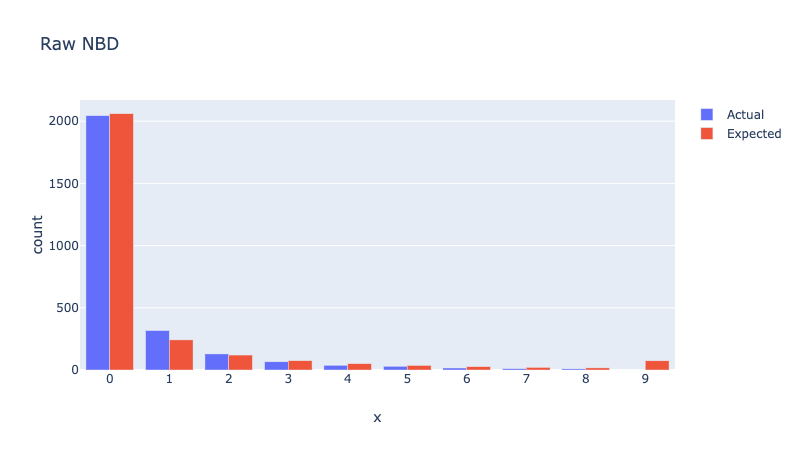

In [694]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=np.arange(10), y=np.unique(data.Visits,return_counts=True)[1][0:9]),
    go.Bar(name='Expected', x=np.arange(10), y=pred)
])

fig.update_layout(title='Raw NBD',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

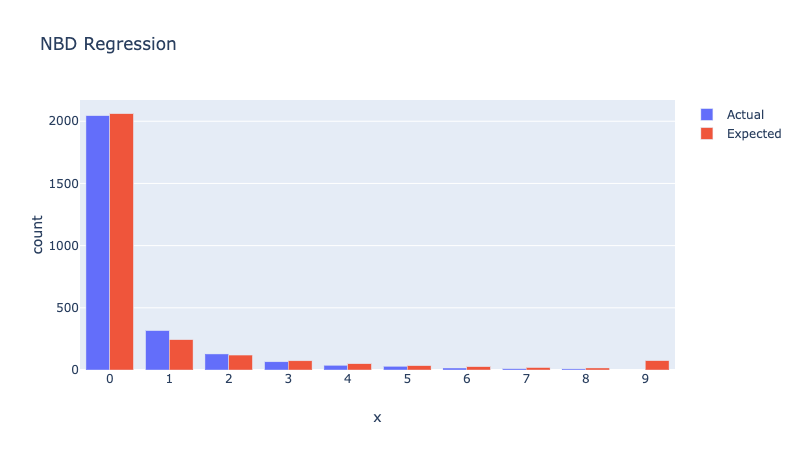

In [695]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=np.arange(10), y=np.unique(data.Visits,return_counts=True)[1][0:9]),
    go.Bar(name='Expected', x=np.arange(10), y=pred2)
])

fig.update_layout(title='NBD Regression',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

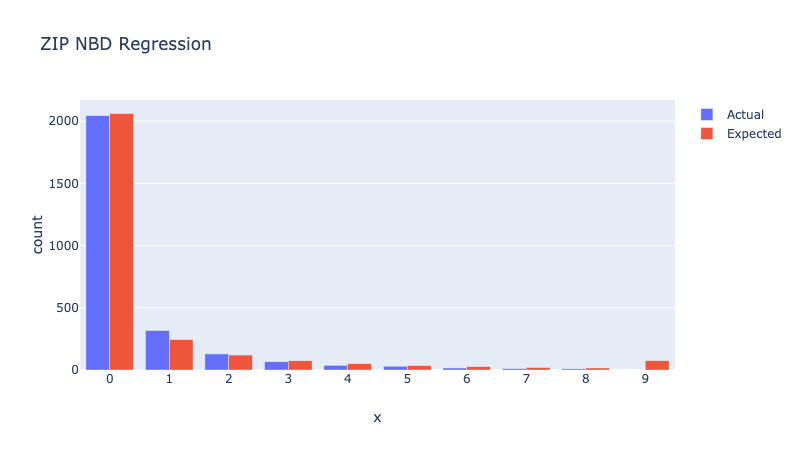

In [656]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=np.arange(10), y=np.unique(data.Visits,return_counts=True)[1][0:9]),
    go.Bar(name='Expected', x=np.arange(10), y=pred3)
])

fig.update_layout(title='ZIP NBD Regression',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

# ML Integration with NBD for variable selection

> Work In Progress

In [838]:
expr = 'Visits ~ Income + Sex + Age + Size'
Y,X = dmatrices(expr, data, return_type='dataframe')
X = X.iloc[:,1:]
residual = Y.iloc[:,0].to_list() - cond
Y = residual.reshape(-1, 1)

In [866]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

In [840]:
Lasso_mod = Lasso(alpha = 0.012,tol=0.0001,max_iter=1000000)
Lasso_mod.fit(X,Y)

Lasso(alpha=0.012, copy_X=True, fit_intercept=True, max_iter=1000000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [841]:
print(X.columns)
print(Lasso_mod.coef_)

Index(['Income', 'Sex', 'Age', 'Size'], dtype='object')
[ 0.        -0.         0.        -0.0024961]


In [842]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, Y.reshape(len(Y), ))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [874]:
print(X.columns)
print(rf.feature_importances_)
import matplotlib.pyplot as plt
print(partial_dependence(estimator = rf,
                              X = X,
                              features=[0]))

Index(['Income', 'Sex', 'Age', 'Size'], dtype='object')
[0.30551008 0.08620703 0.41905876 0.18922412]
(array([[ 0.02386598,  0.02124276,  0.0261854 ,  0.29297322,  0.03629806,
        -0.00288798, -0.0123767 ,  0.02669248, -0.00572551,  0.04711188,
         0.10657544,  0.01180043,  0.01393178, -0.01455978, -0.02604677,
         0.05643974,  0.0013408 ,  0.07001138,  0.01015555,  0.08224986,
         0.04510924,  0.04250159,  0.02558405]]), [array([ 8.92,  9.08,  9.33,  9.53,  9.77,  9.9 , 10.02, 10.22, 10.31,
       10.39, 10.53, 10.66, 10.77, 10.82, 10.92, 11.08, 11.12, 11.19,
       11.38, 11.74, 11.92, 12.07, 12.21])])
